# Recommender system using deep learning

I use here Movielens 100-k dataset for building a recommender system.
The dataset is obtained from here: https://grouplens.org/datasets/movielens. This is a smaller dataset containing 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018.

The well-known way to create a recommender system is to use Matrix factorization. The matrix factorization can be implemented with the methods used in NLP (natural language processing) called embeddings. Embeddings create vectorisation of users and movies, which is similar to creating vectorisation through user- and movie- matrix factorisation.

## 1. Load the movielens data

First, import the needed packages.

In [28]:
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Then load the 100-k Movielens dataset from their web pages: https://grouplens.org/datasets/movielens. 

In [21]:
!wget -nc https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

File ‘ml-latest-small.zip’ already there; not retrieving.



In [22]:
!unzip -n ml-latest-small.zip

Archive:  ml-latest-small.zip


In [23]:
!ls

ml-latest-small  ml-latest-small.zip  sample_data


## 2. Explore the movielens data

The data are contained in the files links.csv, movies.csv, ratings.csv and tags.csv.  Let's look at the ratings file.

In [24]:
ratings_file=pd.read_csv('ml-latest-small/ratings.csv')
ratings_file.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [25]:
len(ratings_file)

100836

## 3. Create user, movie and ratings vectors

Let's turn the userIds and movieIds into categories to ensure that numbering starts from 0 and that there are no numbers skipped in the ids, since movielens 100k dataset is a stripped version of a bigger dataset.

In [8]:
ratings_file['userId']=pd.Categorical(ratings_file.userId)
ratings_file['movieId']=pd.Categorical(ratings_file.movieId)
# Create new columns containing category codes
ratings_file['userId_cat_code']=ratings_file.userId.cat.codes
ratings_file['movieId_cat_code']=ratings_file.movieId.cat.codes

In [9]:
ratings_file.head()

,userId,movieId,rating,timestamp,userId_cat_code,movieId_cat_code
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46


Create numpy arrays, containing categorical userIds, movieIds and ratings

In [10]:
user_ids=ratings_file['userId_cat_code'].values
movie_ids=ratings_file['movieId_cat_code'].values
ratings=ratings_file['rating'].values

In [16]:
user_ids[0:5]

array([0, 0, 0, 0, 0], dtype=int16)

In [17]:
movie_ids[0:5]

array([ 0,  2,  5, 43, 46], dtype=int16)

In [18]:
ratings[0:5]

array([4., 4., 4., 5., 5.])

Find out the distinct number of users and movies.

And define the embedding dimension. That defines the lengths of a user vector and movie vector.

In [19]:
N=len(set(user_ids))
M=len(set(movie_ids))
K=10
print(f"Number of users: {N}. Number of movies: {M}, Embedding dimension: {K}.")


Number of users: 610. Number of movies: 9724, Embedding dimension: 10.


## 4. Create the neural network for recommendation system

The idea is the model is to perform following steps: 
- have two parallel inputs for the model: users and movies
- create embeddings for users and movies, respectively. 
- concatenate the user and movie embedding into one feature vector
- after that use a regular feedforward neural network, with regression output
- the regression output means that there is no activation layer at the output

The idea in the embeddings is following
- The embeddings are similar to user and movie vectors in the matrix factorization, containing the knowledge of user preferences and movie types or genres. 
- A certain user id refers to (and thus selects) a certain row of the user embeddings matrix N * K, of size 1 * K
- A certain movie id refers to (and thus selects) a certain row of the movie embeddings matrix M * K, of size 1 * K



In [42]:
from keras.layers import Input,Embedding,Concatenate,Flatten,Dense
from keras import Model

In [36]:
# Two parallel inputs : users and movies
users=Input(shape=(1,)) 
movies=Input(shape=(1,)) 
# Create user and movie embeddings. 
user_embedding=Embedding(N,K)(users) # output from this is (num_samples,1,K)
movie_embedding=Embedding(M,K)(movies) # output from this is (num_samples,1,K)
# Flatten the embeddings so that they can be concatenated together
user_embedding=Flatten()(user_embedding) # Flatten it to size (num_samples,K)
movie_embedding=Flatten()(movie_embedding) # Flatten it to size (num_samples,K)
# Concatenate the user and movie embeddings into a feature vector
x=Concatenate()([user_embedding,movie_embedding]) # output is (num_samples, 2*K)
# Input the feature vector into a feed forward neural network 
x = Dense(1024,activation='relu')(x)
# Output is a regression, thus without activation layer
x=Dense(1)(x)

Compile the model. Pass the inputs as a list, since the model assumes two inputs.

In [43]:
# Create optimizer
opt = keras.optimizers.SGD(learning_rate=0.8,momentum=0.9)

In [44]:
rec_model=Model(inputs=[users,movies],outputs=x)
rec_model.compile(loss='mse',optimizer=opt)

## 5. Create the training and test data sets

Let's define that the training set is 80 % of the data.

In [45]:
user_ids, movie_ids,ratings = shuffle(user_ids,movie_ids,ratings)
samples_train=int(0.8*len(ratings))
user_train=user_ids[:samples_train]
movie_train=movie_ids[:samples_train]
ratings_train=ratings[:samples_train]
user_test=user_ids[samples_train:]
movie_test=movie_ids[samples_train:]
ratings_test=ratings[samples_train:]

Modify the ratings so that the values are centered at zero.

In [46]:
ratings_mean=ratings_train.mean()
ratings_train=ratings_train-ratings_mean
ratings_test=ratings_test-ratings_mean
ratings_train[0:5]

array([-3.00147518,  0.49852482,  1.49852482,  0.49852482, -1.50147518])

In [47]:
ratings_mean

3.501475182228393

## 6. Train the recommendation model

Input is again given as a list, since the model has two inputs.

In [49]:
rec=rec_model.fit(
    x=[user_train,movie_train],
    y=ratings_train,
    epochs=25,
    batch_size=1024,
    verbose=2,
    validation_data=([user_test,movie_test],ratings_test)
)

Epoch 1/25
79/79 - 2s - loss: 0.9911 - val_loss: 0.8588 - 2s/epoch - 26ms/step
Epoch 2/25
79/79 - 1s - loss: 0.8229 - val_loss: 0.8081 - 966ms/epoch - 12ms/step
Epoch 3/25
79/79 - 1s - loss: 0.7748 - val_loss: 0.8107 - 974ms/epoch - 12ms/step
Epoch 4/25
79/79 - 1s - loss: 0.7466 - val_loss: 0.7851 - 928ms/epoch - 12ms/step
Epoch 5/25
79/79 - 1s - loss: 0.6934 - val_loss: 0.7575 - 967ms/epoch - 12ms/step
Epoch 6/25
79/79 - 1s - loss: 0.6845 - val_loss: 0.7290 - 890ms/epoch - 11ms/step
Epoch 7/25
79/79 - 1s - loss: 0.6751 - val_loss: 0.7348 - 877ms/epoch - 11ms/step
Epoch 8/25
79/79 - 1s - loss: 0.6378 - val_loss: 0.7368 - 868ms/epoch - 11ms/step
Epoch 9/25
79/79 - 1s - loss: 0.6329 - val_loss: 0.7318 - 857ms/epoch - 11ms/step
Epoch 10/25
79/79 - 1s - loss: 0.6282 - val_loss: 0.8329 - 880ms/epoch - 11ms/step
Epoch 11/25
79/79 - 1s - loss: 0.6341 - val_loss: 0.7600 - 963ms/epoch - 12ms/step
Epoch 12/25
79/79 - 1s - loss: 0.5937 - val_loss: 0.7491 - 917ms/epoch - 12ms/step
Epoch 13/25
79/7

Plot losses

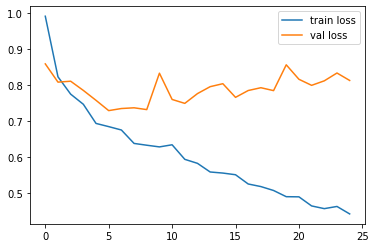

In [50]:
plt.plot(rec.history['loss'], label='train loss')
plt.plot(rec.history['val_loss'], label='val loss')
plt.legend()
plt.show()

## 7. Benchmarking with other approaches

Benchmark result for movielens 100k dataset, see : https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k

The best result: RMSE=0.890, but not clear if it is done with the most recent 100k dataset, since they seem to update it continuously.

So the result from the rec_model is comparable.